In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [22]:
df = pd.read_excel('./data_set/coinmarketcap_bitcoin_0224.xlsx')

#df = pd.read_csv('D:/ml/Stock-Prediction-Models-master/dataset/GOOG-year.csv')
df.head()

,날짜,시가*,고가,저가,종가**,거래량,시가총액
0,2020-02-24,9921.58,9951.75,9537.04,9650.17,45080496648,175977808526
1,2020-02-23,9663.32,9937.40,9657.79,9924.52,41185185761,180963233540
2,2020-02-22,9687.71,9698.23,9600.73,9663.18,35838025154,176180696548
3,2020-02-21,9611.78,9723.01,9589.74,9686.44,40930547513,176587087363
4,2020-02-20,9629.33,9643.22,9507.90,9608.48,44925260237,175147142158


In [23]:
df.tail()

,날짜,시가*,고가,저가,종가**,거래량,시가총액
2488,2013-05-03,106.25,108.13,79.10,97.75,0,1085995169
2489,2013-05-02,116.38,125.60,92.28,105.21,0,1168517495
2490,2013-05-01,139.00,139.89,107.72,116.99,0,1298954594
2491,2013-04-30,144.00,146.93,134.05,139.00,0,1542813125
2492,2013-04-29,134.44,147.49,134.00,144.54,0,1603768865


In [26]:
df = df.sort_index(ascending=0)

In [27]:
df.reset_index(inplace=True)

In [28]:
df.head()

,index,날짜,시가*,고가,저가,종가**,거래량,시가총액
0,2492,2013-04-29,134.44,147.49,134.00,144.54,0,1603768865
1,2491,2013-04-30,144.00,146.93,134.05,139.00,0,1542813125
2,2490,2013-05-01,139.00,139.89,107.72,116.99,0,1298954594
3,2489,2013-05-02,116.38,125.60,92.28,105.21,0,1168517495
4,2488,2013-05-03,106.25,108.13,79.10,97.75,0,1085995169


In [29]:
df.iloc[:, 5:6]

,종가**
0,144.54
1,139.00
2,116.99
3,105.21
4,97.75
...,...
2488,9608.48
2489,9686.44
2490,9663.18
2491,9924.52


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2493 entries, 0 to 2492
Data columns (total 8 columns):
index    2493 non-null int64
날짜       2493 non-null datetime64[ns]
시가*      2493 non-null float64
고가       2493 non-null float64
저가       2493 non-null float64
종가**     2493 non-null float64
거래량      2493 non-null int64
시가총액     2493 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 155.9 KB


In [31]:
minmax = MinMaxScaler().fit(df.iloc[:, 5:6].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 5:6].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.003917
1,0.003632
2,0.002499
3,0.001893
4,0.001509


In [32]:
simulation_size = 10
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
test_size = 30
learning_rate = 0.01

df_train = df_log
df.shape, df_train.shape

((2493, 8), (2493, 1))

In [33]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer,
                                           state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer,
            dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [34]:
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

In [35]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [36]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.4)
    
    return deep_future

In [37]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


train loop:  26%|███████████▎                                | 77/300 [06:41<20:13,  5.44s/it, acc=98.4, cost=0.000822]

KeyboardInterrupt: 

In [16]:
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
for i in range(test_size):
    date_ori.append(date_ori[-1] + timedelta(days = 1))
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()
date_ori[-5:]

['2017-11-27', '2017-11-28', '2017-11-29', '2017-11-30', '2017-12-01']

In [17]:
accepted_results = []
for r in results:
    if (np.array(r[-test_size:]) < np.min(df['Close'])).sum() == 0 and \
    (np.array(r[-test_size:]) > np.max(df['Close']) * 2).sum() == 0:
        accepted_results.append(r)
len(accepted_results)

10

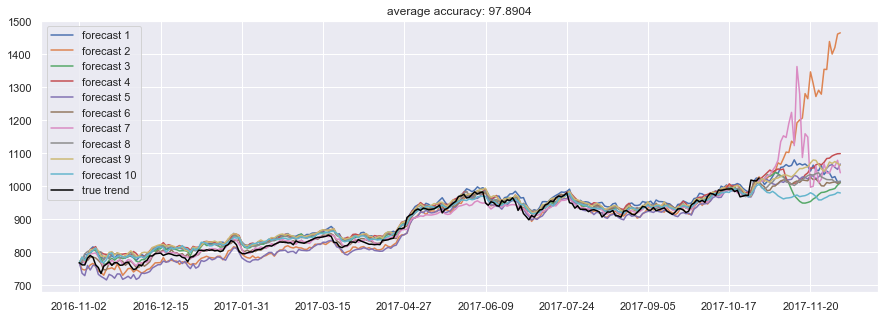

In [18]:
accuracies = [calculate_accuracy(df['Close'].values, r[:-test_size]) for r in accepted_results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(accepted_results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'], label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))

x_range_future = np.arange(len(results[0]))
plt.xticks(x_range_future[::30], date_ori[::30])

plt.show()